<a href="https://colab.research.google.com/github/Spyroslon/Thermal-Object-Detection-HRNet/blob/main/1_Dataset_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dataset Processing

The purpose of this notebook is to visualize the distrubtion of annotated classes between the different directories and to modify the annotation files so they can be used by the MMDetection library in the training and testing process.

The dataset used in this project is the FREE FLIR Thermal Dataset for Algorithm Training https://www.flir.com/oem/adas/adas-dataset-form/.

It can be downloaded by requesting access to it through their main website or by using the links provided https://flir.app.box.com/s/1z1wn8e5b9ff0vvcc589l1m5529smrnx and https://www.kaggle.com/deepnewbie/flir-thermal-images-dataset.

All 3 directories train, val and video are used but with only their thermal_8_bit image files. The RGB and thermal_16_bit images where not used. Each directory contains annotation information in the MSCOCO format stored in a json file.

To be properly used the data must be in the structure shown below:

- train
    - thermal_annotations.json
    - thermal_8_bit
        - FLIR_00001.jpeg
        - FLIR_00002.jpeg
        -...

- val
    - thermal_annotations.json
    - thermal_8_bit
        - FLIR_08863.jpeg
        - FLIR_08864.jpeg
        -...

- video
    - thermal_annotations.json
    - thermal_8_bit
        - FLIR_video_00001.jpeg
        - FLIR_video_00002.jpeg
        -...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Modify to the appropriate path
%cd '/content/drive/MyDrive/Thermal Detection'

/content/drive/MyDrive/Thermal Detection


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

In [ ]:
def category_distribution(path):
  # Class for obtaining the annotation distribution between the classes
  # for the given path
  with open(f"{path}/thermal_annotations.json", "r") as f:
      json_object = json.load(f)

  annot_distribution = {}

  for annot in json_object['annotations']:
      if annot['category_id'] not in annot_distribution:
        annot_distribution[annot['category_id']] = 1
      else:
        annot_distribution[annot['category_id']] += 1

  for cat in json_object['categories']:
    if cat['id'] in annot_distribution.keys():
      annot_distribution[cat['name']] = annot_distribution.pop(cat['id'])

  sns.barplot(x=list(annot_distribution.keys()), y=list(annot_distribution.values()))
  plt.title(f'{path} Class Distrubution')
  annot_distribution_df = pd.DataFrame([annot_distribution])

  return annot_distribution_df

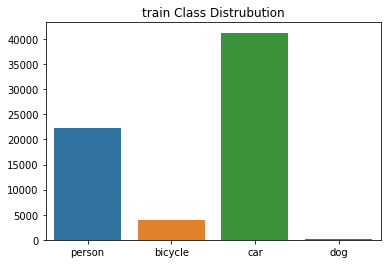

In [ ]:
train_distribution = category_distribution('train')

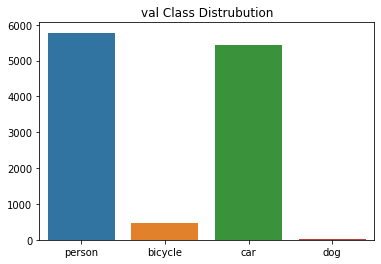

In [ ]:
val_distribution = category_distribution('val')

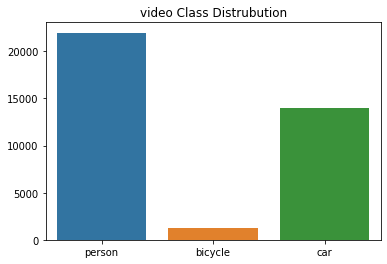

In [ ]:
video_distribution = category_distribution('video')

In [ ]:
unique_categories = train_distribution.columns.to_list()
unique_categories.remove('dog')
unique_categories

['person', 'bicycle', 'car']

In [ ]:
def generate_valid_json(path):
  # Used to create a new modified version of the given annotation files
  # to a format that can be used by the MMDetection library
  # as to also remove the dog annotations

  # Storing the contents of the thermal annotations json file
  with open(f"{path}/thermal_annotations.json", "r") as f:
      json_object = json.load(f)

  # Replacing the categories to only contain the 3 that are present in
  # the dataset whilst also also excluding the dog category
  unique_categories_json = []
  category_ids = []
  for category in json_object['categories']:
      if category['name'] in unique_categories:
          unique_categories_json.append(category)
          category_ids.append(category['id'])

  json_object['categories'] = unique_categories_json

  # Removing annotations that are not of the 3 categories (car, bicycle, person)
  valid_annotations_json = []
  for annotation in json_object['annotations']:
      if annotation['category_id'] in category_ids:
        valid_annotations_json.append(annotation)

  json_object['annotations'] = valid_annotations_json

  path_images_list = os.listdir(f'{path}/thermal_8_bit')
  remove_indexes = []
  # Removing the path from the filename the file_name and skipping
  # any image_names not present in the thermal_8_bit folder
  for image in json_object['images']:
      if image['file_name'].split('/')[1] not in path_images_list:
          remove_indexes.append(json_object['images'].index(image))
      else:
          image['file_name'] = image['file_name'].split('/')[1]

  # Deleting images in reverse so we dont throw off the subsequent indexes.
  for index in sorted(remove_indexes, reverse=True):
      del json_object['images'][index]

  # Creating the new thermal_annotations json file using the updated object
  with open(f'{path}/thermal_annotations_v2.json', 'w', encoding='utf-8') as f:
      json.dump(json_object, f, ensure_ascii=False, indent=2)
      print(f'{path}/thermal_annotations_v2.json' + ' created!')


In [ ]:
generate_valid_json('train')

train/thermal_annotations_v2.json created!


In [ ]:
generate_valid_json('val')

val/thermal_annotations_v2.json created!


In [ ]:
generate_valid_json('video')

video/thermal_annotations_v2.json created!
